# Approximate q-learning (5 pts)

In this notebook you will teach a __pytorch__ neural network to do Q-learning.

In [13]:
# in google colab uncomment this

# import os

# os.system('apt-get update')
# os.system('apt-get install -y xvfb')
# os.system('wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall18/xvfb -O ../xvfb')
# os.system('apt-get install -y python-opengl ffmpeg')
# os.system('pip install pyglet==1.5.0')

# XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

In [14]:
import gym
from segwey import segwey
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
env = segwey()
env.set_param(discrete_level = 10, max_u = 100)
print("discrete_level", env.discrete_level)
print("max_u", env.max_u)
s = env.reset()
n_actions = env.n_actions
state_dim = env.state_dim
print(s)

print((n_actions), (state_dim))

discrete_level 10
max_u 100
[0.         0.56737593 0.         0.        ]
21 (4,)


# Approximate Q-learning: building the network

To train a neural network policy one must have a neural network policy. Let's build it.


Since we're working with a pre-extracted features (cart positions, angles and velocities), we don't need a complicated network yet. In fact, let's build something like this for starters:

![img](https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/yet_another_week/_resource/qlearning_scheme.png)

For your first run, please only use linear layers (nn.Linear) and activations. Stuff like batch normalization or dropout may ruin everything if used haphazardly. 

Also please avoid using nonlinearities like sigmoid & tanh: agent's observations are not normalized so sigmoids may become saturated from init.

Ideally you should start small with maybe 1-2 hidden layers with < 200 neurons and then increase network size if agent doesn't beat the target score.

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [17]:
network = nn.Sequential()

network.add_module('layer1', nn.Linear(state_dim[0], 64))
network.add_module('relu1', nn.ReLU())
network.add_module('layer2', nn.Linear(64, 64))
network.add_module('relu2', nn.ReLU())
network.add_module('layer3', nn.Linear(64, n_actions))

# hint: use state_dim[0] as input size

In [18]:
def get_action(state, epsilon=0):
    """
    sample actions with epsilon-greedy policy
    recap: with p = epsilon pick random action, else pick action with highest Q(s,a)
    """
    state = torch.tensor(state[None], dtype=torch.float32)
    q_values = network(state).detach().numpy()
    
    action = np.argmax(q_values)
    if np.random.binomial(1,p=epsilon):
        action = np.random.choice(range(q_values.shape[-1]))

    return int( action )

In [19]:
s = env.reset()
assert tuple(network(torch.tensor([s]*3, dtype=torch.float32)).size()) == (
    3, n_actions), "please make sure your model maps state s -> [Q(s,a0), ..., Q(s, a_last)]"
assert isinstance(list(network.modules(
))[-1], nn.Linear), "please make sure you predict q-values without nonlinearity (ignore if you know what you're doing)"
assert isinstance(get_action(
    s), int), "get_action(s) must return int, not %s. try int(action)" % (type(get_action(s)))

# test epsilon-greedy exploration
for eps in [0., 0.1, 0.5, 1.0]:
    state_frequencies = np.bincount(
        [get_action(s, epsilon=eps) for i in range(10000)], minlength=n_actions)
    best_action = state_frequencies.argmax()
    assert abs(state_frequencies[best_action] -
               10000 * (1 - eps + eps / n_actions)) < 200
    for other_action in range(n_actions):
        if other_action != best_action:
            assert abs(state_frequencies[other_action] -
                       10000 * (eps / n_actions)) < 200
    print('e=%.1f tests passed' % eps)

e=0.0 tests passed
e=0.1 tests passed
e=0.5 tests passed
e=1.0 tests passed


### Q-learning via gradient descent

We shall now train our agent's Q-function by minimizing the TD loss:
$$ L = { 1 \over N} \sum_i (Q_{\theta}(s,a) - [r(s,a) + \gamma \cdot max_{a'} Q_{-}(s', a')]) ^2 $$


Where
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor defined two cells above.

The tricky part is with  $Q_{-}(s',a')$. From an engineering standpoint, it's the same as $Q_{\theta}$ - the output of your neural network policy. However, when doing gradient descent, __we won't propagate gradients through it__ to make training more stable (see lectures).

To do so, we shall use `x.detach()` function which basically says "consider this thing constant when doingbackprop".

In [20]:
def compute_td_loss(states, actions, rewards, next_states, is_done, gamma=0.99, check_shapes=False):
    """ Compute td loss using torch operations only. Use the formula above. """
    states = torch.tensor(
        states, dtype=torch.float32)    # shape: [batch_size, state_size]
    actions = torch.tensor(actions, dtype=torch.long)    # shape: [batch_size]
    rewards = torch.tensor(rewards, dtype=torch.float32)  # shape: [batch_size]
    # shape: [batch_size, state_size]
    next_states = torch.tensor(next_states, dtype=torch.float32)
    is_done = torch.tensor(is_done, dtype=torch.uint8)  # shape: [batch_size]

    # get q-values for all actions in current states
    predicted_qvalues = network(states)

    # select q-values for chosen actions
    predicted_qvalues_for_actions = predicted_qvalues[
      range(states.shape[0]), actions
    ]

    # compute q-values for all actions in next states
    predicted_next_qvalues = network(next_states)

    # compute V*(next_states) using predicted next q-values
    next_state_values =  torch.max(predicted_next_qvalues, dim=-1)[0]
    assert next_state_values.dtype == torch.float32

    # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
    target_qvalues_for_actions =  rewards + gamma*next_state_values

    # at the last state we shall use simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
    target_qvalues_for_actions = torch.where(
        is_done, rewards, target_qvalues_for_actions)

    # mean squared error loss to minimize
    loss = torch.mean((predicted_qvalues_for_actions -
                       target_qvalues_for_actions.detach()) ** 2)

    if check_shapes:
        assert predicted_next_qvalues.data.dim(
        ) == 2, "make sure you predicted q-values for all actions in next state"
        assert next_state_values.data.dim(
        ) == 1, "make sure you computed V(s') as maximum over just the actions axis and not all axes"
        assert target_qvalues_for_actions.data.dim(
        ) == 1, "there's something wrong with target q-values, they must be a vector"

    return loss

In [21]:
# sanity checks
s = env.reset()
a = get_action(s)
next_s, r, done, _ = env.step(a)
loss = compute_td_loss([s], [a], [r], [next_s], [done], check_shapes=True)
loss.backward()

assert len(loss.size()) == 0, "you must return scalar loss - mean over batch"
assert np.any(next(network.parameters()).grad.detach().numpy() !=
              0), "loss must be differentiable w.r.t. network weights"

### Playing the game

In [29]:
opt = torch.optim.Adam(network.parameters(), lr=1e-4)
epsilon = 0.1

In [27]:
def generate_session(t_max=1000, epsilon=0, train=False):
    """play env with approximate q-learning agent and train it at the same time"""
    total_reward = 0
    s = env.reset()

    for t in range(t_max):
        a = get_action(s, epsilon=epsilon)
        next_s, r, done, _ = env.step(a)
        r = r*0.95 + next_s[1]*0.05
        if train:
            opt.zero_grad()
            loss = compute_td_loss([s], [a], [r], [next_s], [done])
            loss.backward()
            opt.step()

        total_reward += r
        s = next_s
        if done:
            break

    return np.array([total_reward, float(loss)])

In [42]:
mean_rewards=np.array([[0,0]])
for i in range(1000):
    session_rewards = np.array([generate_session(
        epsilon=epsilon, train=True) for _ in range(100)])
    print("epoch #{}\tmean reward = {:.3f}\tloss = {:.3f}\tepsilon = {:.3f}".format(
        i, np.mean(session_rewards[:,0]), np.mean(session_rewards[:,1]), epsilon))
    mean_rewards = np.vstack([mean_rewards, [np.mean(session_rewards[:,0]), np.mean(session_rewards[:,1])]])
#     epsilon *= 0.99
    assert epsilon >= 1e-4, "Make sure epsilon is always nonzero during training"
#     plt.plot(range(len(mean_rewards)), mean_rewards)
    if np.mean(session_rewards[:,0]) > 500:
        print("You Win!")
        break

epoch #0	mean reward = 628.786	loss = 2756.047	epsilon = 0.100
You Win!


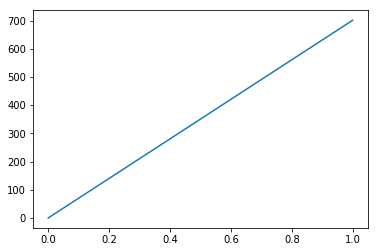

In [31]:
plt.plot(range(len(mean_rewards)), mean_rewards[:,0])

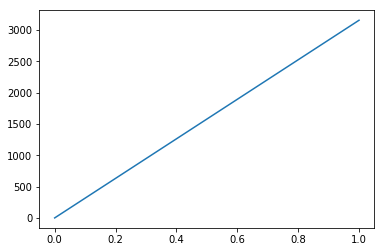

In [126]:
plt.plot(range(len(mean_rewards)), mean_rewards[:,1])

### How to interpret results


Welcome to the f.. world of deep f...n reinforcement learning. Don't expect agent's reward to smoothly go up. Hope for it to go increase eventually. If it deems you worthy.

Seriously though,
* __ mean reward__ is the average reward per game. For a correct implementation it may stay low for some 10 epochs, then start growing while oscilating insanely and converges by ~50-100 steps depending on the network architecture. 
* If it never reaches target score by the end of for loop, try increasing the number of hidden neurons or look at the epsilon.
* __ epsilon__ - agent's willingness to explore. If you see that agent's already at < 0.01 epsilon before it's is at least 200, just reset it back to 0.1 - 0.5.

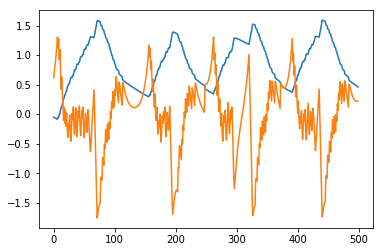

In [44]:
s = env.reset()
X=[]
for t in range(500):
    a = get_action(s)
    s, r, done, _ = env.step(a)
    X.append(s)
    if done:
        break

plt.plot(range(len(X)),np.array(X)[:,[0,1]])

In [144]:
torch.save(network.state_dict(), "segwey_network_defoult.pt")